In [1]:
import numpy as np
import pandas as pd
import os, time
import itertools
from time import time

from pandas import read_csv, Series, DataFrame
from pandas.tools.plotting import autocorrelation_plot

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA, ARMA, AR
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt
%pylab inline

from matplotlib.pylab import rcParams
rcParams['font.family'] = 'Ubuntu'
rcParams['lines.linewidth'] = 2.5
rcParams['figure.figsize'] = 14, 4

/miniconda/envs/ts-env/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Populating the interactive namespace from numpy and matplotlib


## Functions

In [2]:
def run_sm_arima(y=Series(), ORDER=tuple(), fh=int()):
    """
    """
    y_tr = y.iloc[:-fh]
    y_te = Series(y.iloc[-fh:].values, index=pd.date_range(start=y.index[-fh], periods=fh))

    m = ARIMA(endog=y_tr, order=ORDER).fit()
    yhat, err, ci = m.forecast(steps=fh)

    df = \
    pd.concat([
        Series(y_te).to_frame('y'),
        Series(yhat, index=y_te.index).to_frame('yhat'),
        DataFrame(ci, columns=['yhat_lower', 'yhat_upper'], index=y_te.index)], axis=1)

    return {'model': m,
           'order': ORDER,
           'model_aic': m.aic,
           'model_rmse': get_perf_metrics(df).get('RMSE'),
           'model_mape': get_perf_metrics(df).get('MAPE'),
           'df': df}

In [3]:
def run_sm_arimax(y=Series(), Xs=DataFrame(), ORDER=tuple(), fh=int()):
    """
    """
    y_tr = y.iloc[:-fh]
    y_te = Series(y.iloc[-fh:].values, index=pd.date_range(start=y.index[-fh], periods=fh))

    X_tr = X.loc[y_tr.index]
    X_te = X.loc[y_te.index]

    try:
        m = ARIMA(endog=y_tr, order=ORDER, exog=X_tr).fit()

        yhat, err, ci = m.forecast(steps=fh, exog=X_te)

        df = \
        pd.concat([
            Series(y_te).to_frame('y'),
            Series(yhat, index=y_te.index).to_frame('yhat'),
            DataFrame(ci, columns=['yhat_lower', 'yhat_upper'], index=y_te.index)], axis=1)

        return {'model': m,
               'order': ORDER,
               'model_aic': m.aic,
               'model_rmse': get_perf_metrics(df).get('RMSE'),
               'model_mape': get_perf_metrics(df).get('MAPE'),
               'df': df}
    except:
        print("Failed for order {}".format(ORDER))
        pass

In [4]:
def visualize_forecasts(y=Series(), df=DataFrame(), fh=int()):
    """
    """
    fig, ax = plt.subplots(figsize=(15, 5))
    
    y.to_frame(name='y').iloc[-fh * 3:, :].plot(ax=ax)
    ax_1 = df.drop('y', axis=1).plot(ax=ax, color=('r', 'k', 'k'), alpha=0.3)
    ax_1.fill_between(df.index, df['yhat_upper'], df['yhat_lower'], color='k', alpha=.2)

In [5]:
def get_perf_metrics(df_predicted):
    """
    """
    y = df_predicted['y'].copy()
    yhat = df_predicted['yhat'].copy()
    
    mse = np.mean((y - yhat)**2)
    perc_err = (100*(y - yhat))/y
    
    return {'RMSE': np.sqrt(mse), 
            'MAPE': np.mean(abs(perc_err))}

---
## Explore the time-series for trend, seasonality, outliers

/miniconda/envs/ts-env/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


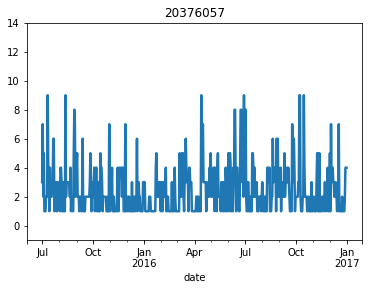

In [6]:
df_sales = pd.read_csv("../data/ts-data-few-missings.csv", parse_dates=['date']).set_index('date').loc['2015-07':]
df_holidays = pd.read_csv("../data/ts-holidays.csv", parse_dates=['date'])

ITEM = Series(df_sales.columns.tolist()).sample(1).iloc[0]
y = df_sales[ITEM].copy()

# clean
y.fillna(method='bfill', inplace=True)
y = y.clip_upper(y.quantile(0.99)).clip_lower(y.quantile(0.01))
y.dropna(inplace=True)

# visualize
y.plot(title=ITEM, ylim=(-1, y.max() + 5));

## Create Predictors

In [7]:
df_sales = pd.concat([y.to_frame(name='y'), 
                      df_holidays.set_index('date')], axis=1).reset_index()

df_sales.loc[:, 'date'] = pd.to_datetime(df_sales['date'])
dummies_month = pd.get_dummies(df_sales.date.dt.month, prefix='month')
dummies_weekday = pd.get_dummies(df_sales.date.dt.weekday, prefix='dayofweek')

df_sales.loc[:, 'is_weekend'] = df_sales.date.dt.weekday.map(lambda x: x > 4).astype(int)

df_sales.loc[:, 'is_holiday'] = df_sales.is_holiday.fillna(0)
df_sales.loc[:, 'days_before_holidays'] = (pd.concat([df_sales['is_holiday'].shift(-i) for i in [1, 2]], axis=1)
                                           .sum(axis=1)
                                           .fillna(0)
                                           .astype(int)
                                           .map(lambda x: 1 if x > 1 else x))

df_sales.loc[:, 'days_after_holidays'] = (pd.concat([df_sales['is_holiday'].shift(i) for i in [1, 2]], axis=1)
                                           .sum(axis=1)
                                          .fillna(0)
                                          .astype(int)
                                          .map(lambda x: 1 if x > 1 else x))


df_sales = pd.concat([df_sales, dummies_month, dummies_weekday], axis=1)

y = Series(data=df_sales['y'].values, index=pd.to_datetime(df_sales['date']))

X = df_sales.set_index('date').drop(['y'], axis=1)
X.columns

Index(['is_holiday', 'is_weekend', 'days_before_holidays',
       'days_after_holidays', 'month_1', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'month_12', 'dayofweek_0', 'dayofweek_1', 'dayofweek_2',
       'dayofweek_3', 'dayofweek_4', 'dayofweek_5', 'dayofweek_6'],
      dtype='object')

## Grid Search ARIMA

In [10]:
p = q = range(3)
d = range(2)
grid = list(itertools.product(p, d, q))

list_gs = []
for pdq in grid[1:]:
    """
    """
    import warnings
    warnings.filterwarnings("ignore")
    result = run_sm_arima(y=y.copy(), ORDER=pdq, fh=30)
    try:
        list_gs.append(Series({k:result.get(k) for k in ['order', 'model_rmse', 'model_mape', 'model_aic', 'df']}))
    except:
        continue

df_order_select__ARIMA = pd.concat(list_gs, axis=1).T.set_index('order').round(2)

In [11]:
winner = df_order_select__ARIMA['model_aic'].map(np.float).idxmin()
print("The winning order is {}".format(winner))
df_predicted__ARIMA = df_order_select__ARIMA.loc[[winner], 'df'].iloc[0]

The winning order is (0, 0, 2)


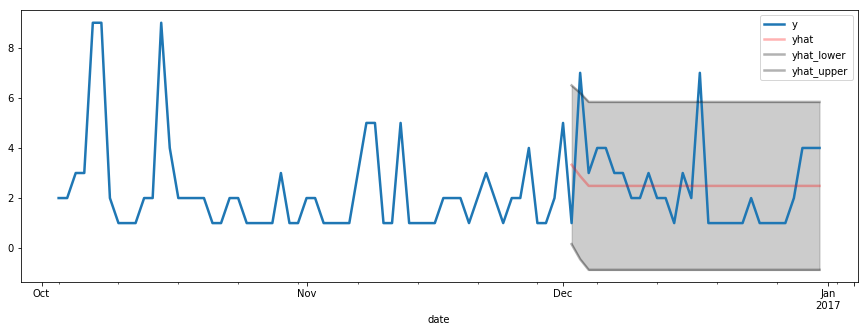

In [12]:
visualize_forecasts(y=y, df=df_predicted__ARIMA, fh=30)

### Grid Search ARIMAX

In [13]:
p = q = range(3)
d = range(2)
grid = list(itertools.product(p, d, q))

list_gs = []
for pdq in grid[1:]:
    """
    """
    import warnings
    warnings.filterwarnings("ignore")
    result = run_sm_arimax(y=y.copy(), Xs=X.copy(), ORDER=pdq, fh=30)
    try:
        list_gs.append(Series({k:result.get(k) for k in ['order', 'model_rmse', 'model_mape', 'model_aic', 'df']}))
    except:
        continue

df_order_select__ARIMAX = pd.concat(list_gs, axis=1).T.set_index('order').round(2)
winner = df_order_select__ARIMAX['model_aic'].map(np.float).idxmin()
print("The winning order is {}".format(winner))
df_predicted__ARIMAX = df_order_select__ARIMAX.loc[[winner], 'df'].iloc[0]

The winning order is (0, 0, 2)


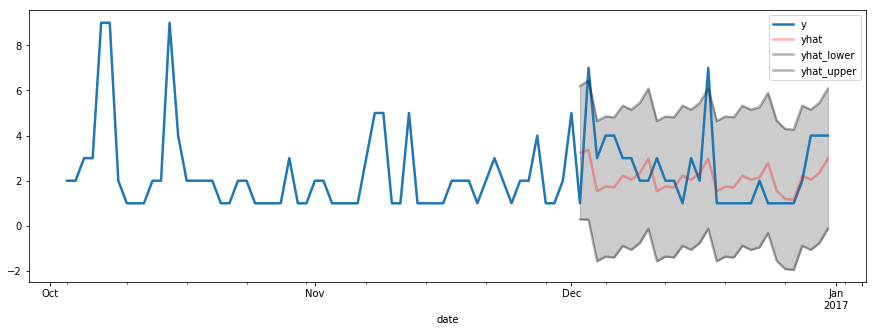

In [14]:
visualize_forecasts(y=y.copy(), df=df_predicted__ARIMAX, fh=30)